In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
from pathlib import Path
from glob import glob
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import torch.optim as optim
from sklearn.metrics import accuracy_score
import numpy as np

In [3]:
def apply_clahe(image):
    # Convert PIL Image to NumPy array
    image_np = np.array(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image_np = clahe.apply(image_np)
    return Image.fromarray(clahe_image_np)
class BonesDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = Path(root_folder)
        # Get list of class folders
        self.classes = sorted([folder.name for folder in self.root_folder.glob('*') if folder.is_dir()])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        # Load images from both .jpg and .png formats
        self.images = self._load_images()
        self.transform = transform

    def _load_images(self):
        images = []
        for cls in self.classes:
            class_folder = self.root_folder / cls
            class_images = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.png'))
            images.extend([(image, cls) for image in class_images])
        
        if not images:
            raise ValueError(f"No images found in any class subdirectory of {self.root_folder}")
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        # Read the image
        image = Image.open(img_path).convert('L')  # Load as grayscale image
        image = image.resize((224, 224))
        # Apply additional transformations if provided
        if self.transform:
            image = self.transform(image)
        
        target = self.class_to_idx[label]
        return image, target

# Function to calculate mean and std for normalization
def calculate_mean_std(dataset):
    all_images = []
    for img, _ in dataset:
        # Convert each image to a tensor and add to list
        all_images.append(transforms.ToTensor()(img))
    
    # Stack all images to calculate mean and std across the entire dataset
    stacked_images = torch.stack(all_images)
    
    # Calculate mean and standard deviation
    mean = stacked_images.mean(dim=[0, 2, 3]) 
    std = stacked_images.std(dim=[0, 2, 3])    
    return mean, std





In [4]:

train_r = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/train'

train_dataset = BonesDataset(root_folder=train_r, transform=None)
mean, std = calculate_mean_std(train_dataset)

print("Calculated Mean:", mean)
print("Calculated Std:", std)


balanced_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()), 
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()), 
])

train_dataset = BonesDataset(root_folder=train_r, transform=balanced_transform)
val_r = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/val'
val_dataset = BonesDataset(root_folder=val_r, transform=val_transform)


test_r='/kaggle/input/knee-osteoarthritis-dataset-with-severity/test'
test_dataset = BonesDataset(root_folder=test_r, transform=val_transform)



print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing Samples:{len(test_dataset)}")

Calculated Mean: tensor([0.6076])
Calculated Std: tensor([0.1931])
Training samples: 7827
Validation samples: 585
Testing Samples:1374


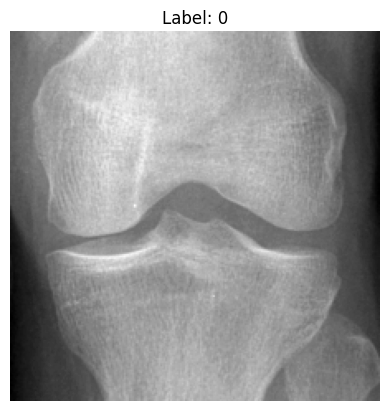

In [5]:

# Function to display a single image from the dataset
def view_preprocessed_image(dataset, idx):
    img, label = dataset[idx]  
    # Display the image using matplotlib
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

view_preprocessed_image(train_dataset, idx=0) 

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ComplexCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(ComplexCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
 
        self.fc1 = nn.Linear(512 * 7 * 7, 1024)
        self.dropout = nn.Dropout(0.30)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = x.view(-1, 512 * 7 * 7)  # Adjusted view to match new feature map size
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexCNN(num_classes=5).to(device)
print(model)

ComplexCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=25088, out_features=1024, bias=True)
 

In [7]:
# Compute class weights
from sklearn.utils.class_weight import compute_class_weight
labels = [label for _, label in train_dataset]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-05)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [9]:
num_epochs = 150
patience = 12  
best_val_loss = float('inf')  
epochs_without_improvement = 0  
train_accuracy = []
train_loss = []
val_accuracy = []
val_loss = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Collect predictions and true labels 
    all_labels_train = []
    all_predictions_train = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        
        all_labels_train.extend(labels.cpu().numpy())
        all_predictions_train.extend(predicted.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_loss.append(avg_train_loss)
    train_accuracy.append(train_acc)

    model.eval()
    correct_val = 0
    total_val = 0
    running_val_loss = 0.0

    all_labels_val = []
    all_predictions_val = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            all_labels_val.extend(labels.cpu().numpy())
            all_predictions_val.extend(predicted.cpu().numpy())

    avg_val_loss = running_val_loss / len(val_loader)
    val_acc = correct_val / total_val
    val_loss.append(avg_val_loss)
    val_accuracy.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc*100:.2f}%")

    # Early Stopping Logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # 
        # Save the model if it improves
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Validation loss improved. Saving model at epoch {epoch+1}.")
    else:
        epochs_without_improvement += 1
        print(f"No improvement in validation loss for {epochs_without_improvement} epoch(s).")

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        break  # Stop training

print("Training complete.")

Epoch [1/150], Train Loss: 1.6935, Train Accuracy: 28.12%, Validation Loss: 1.5371, Validation Accuracy: 39.49%
Validation loss improved. Saving model at epoch 1.
Epoch [2/150], Train Loss: 1.5410, Train Accuracy: 31.08%, Validation Loss: 1.4040, Validation Accuracy: 30.94%
Validation loss improved. Saving model at epoch 2.
Epoch [3/150], Train Loss: 1.2560, Train Accuracy: 39.63%, Validation Loss: 1.1807, Validation Accuracy: 45.47%
Validation loss improved. Saving model at epoch 3.
Epoch [4/150], Train Loss: 1.1698, Train Accuracy: 43.03%, Validation Loss: 1.1923, Validation Accuracy: 45.81%
No improvement in validation loss for 1 epoch(s).
Epoch [5/150], Train Loss: 1.0820, Train Accuracy: 46.15%, Validation Loss: 1.1119, Validation Accuracy: 48.89%
Validation loss improved. Saving model at epoch 5.
Epoch [6/150], Train Loss: 0.9956, Train Accuracy: 51.63%, Validation Loss: 1.1224, Validation Accuracy: 46.84%
No improvement in validation loss for 1 epoch(s).
Epoch [7/150], Train Los

In [10]:

all_labels_val = []
all_predictions_val = []

model.eval()  
with torch.no_grad():  
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels_val.extend(labels.cpu().numpy())  
        all_predictions_val.extend(predicted.cpu().numpy())  


precision = precision_score(all_labels_val, all_predictions_val, average=None)  

recall = recall_score(all_labels_val, all_predictions_val, average=None)        
f1 = f1_score(all_labels_val, all_predictions_val, average=None)                


for i, cls in enumerate(val_dataset.classes):
    print(f"Class {cls} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1 Score: {f1[i]:.4f}")


print(f"Overall Average Precision: {precision.mean():.4f}")
print(f"Overall Average Recall: {recall.mean():.4f}")
print(f"Overall Average F1 Score: {f1.mean():.4f}")


Class 0 - Precision: 0.7982, Recall: 0.7532, F1 Score: 0.7751
Class 1 - Precision: 0.4026, Recall: 0.5849, F1 Score: 0.4769
Class 2 - Precision: 0.7795, Recall: 0.6429, F1 Score: 0.7046
Class 3 - Precision: 0.8906, Recall: 0.7403, F1 Score: 0.8085
Class 4 - Precision: 0.7727, Recall: 1.0000, F1 Score: 0.8718
Overall Average Precision: 0.7287
Overall Average Recall: 0.7443
Overall Average F1 Score: 0.7274


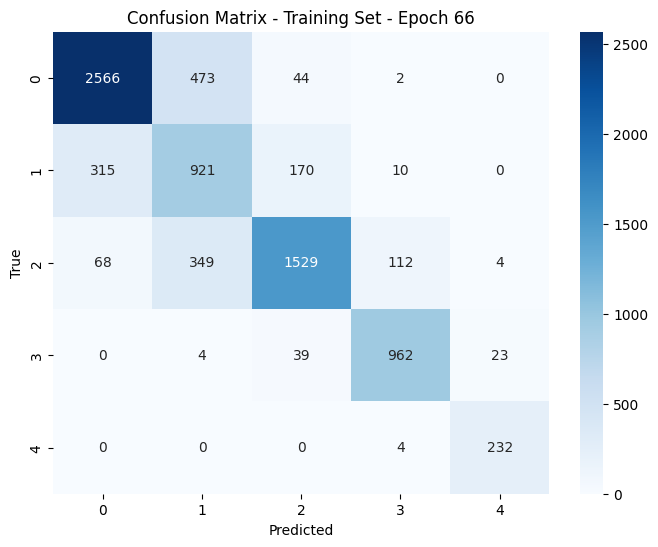

[[2566  473   44    2    0]
 [ 315  921  170   10    0]
 [  68  349 1529  112    4]
 [   0    4   39  962   23]
 [   0    0    0    4  232]]


<Figure size 640x480 with 0 Axes>

In [11]:
cm_train = confusion_matrix(all_labels_train, all_predictions_train)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=val_dataset.classes)
plt.title(f'Confusion Matrix - Training Set - Epoch {epoch+1}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
plt.savefig('/kaggle/working/confusion_matrix_train.png')
print(cm_train)

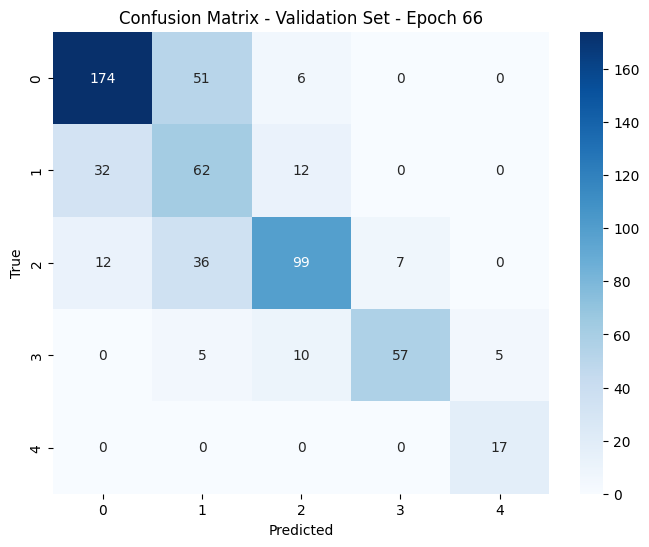

[[174  51   6   0   0]
 [ 32  62  12   0   0]
 [ 12  36  99   7   0]
 [  0   5  10  57   5]
 [  0   0   0   0  17]]


<Figure size 640x480 with 0 Axes>

In [12]:
cm_val = confusion_matrix(all_labels_val, all_predictions_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.title(f'Confusion Matrix - Validation Set - Epoch {epoch+1}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
plt.savefig('/kaggle/working/confusion_matrix_val.png')
print(cm_val)

In [13]:
from sklearn.metrics import roc_auc_score
import numpy as np
all_labels_val = np.array(all_labels_val)
all_predictions_val = np.array(all_predictions_val)

num_classes = len(np.unique(all_labels_val))
all_labels_one_hot = np.eye(num_classes)[all_labels_val]         
all_predictions_one_hot = np.eye(num_classes)[all_predictions_val] 

# Calculate AUC per class
auc_scores = []
for i in range(num_classes):
    try:
        auc = roc_auc_score(all_labels_one_hot[:, i], all_predictions_one_hot[:, i])
        auc_scores.append(auc)
        print(f"Class {i} - AUC: {auc:.4f}")
    except ValueError:
        # Handle cases where AUC can't be calculated (e.g., only one class present in ground truth)
        print(f"Class {i} - AUC: Not computable (only one class present in labels).")

# Calculate and print the overall macro-average AUC
if auc_scores:  # Ensure there's at least one valid AUC score
    macro_avg_auc = np.mean(auc_scores)
    print(f"Overall Average AUC (Macro): {macro_avg_auc:.4f}")
else:
    print("No valid AUC scores available.")

Class 0 - AUC: 0.8145
Class 1 - AUC: 0.6964
Class 2 - AUC: 0.7889
Class 3 - AUC: 0.8632
Class 4 - AUC: 0.9956
Overall Average AUC (Macro): 0.8317


In [14]:

cm = confusion_matrix(all_labels_val, all_predictions_val)

# Calculate accuracy for each class and overall accuracy
class_accuracies = {}
total_correct = 0  
total_samples = cm.sum()  

for i in range(len(cm)):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FN + FP)
    
    # Accuracy formula for each class
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    class_accuracies[f"Class {i}"] = accuracy
    
    # Accumulate true positives for overall accuracy
    total_correct += TP

print("Accuracy per class:")
for cls, acc in class_accuracies.items():
    print(f"{cls}: {acc:.4f}")

overall_accuracy = total_correct / total_samples
print(f"Overall Accuracy: {overall_accuracy:.4f}")

Accuracy per class:
Class 0: 0.8274
Class 1: 0.7675
Class 2: 0.8581
Class 3: 0.9538
Class 4: 0.9915
Overall Accuracy: 0.6991


In [15]:
model.load_state_dict(torch.load('best_model.pth'))
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss/len(test_loader):.4f}")
print(f"Test Accuracy: {100 * correct_test / total_test:.2f}%")


/tmp/ipykernel_30/4205160559.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Loss: 0.7602
Test Accuracy: 67.54%
